<a href="https://colab.research.google.com/github/SalvatoreAdalberto/mlapp/blob/main/6_DL_confidence_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ROOTDIR_DATA = '/content/drive/MyDrive/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ResNet18

In [4]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

class ResNet(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

# Dataset

In [5]:
(mnist_train, mnist_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

mnist_train = mnist_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(ds_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


`tf.data.Dataset` objects can be converted to `pandas.DataFrame` with tfds.as_dataframe to be visualized on Colab.

N.B. Do not shuffle test dataset

In [6]:
mnist_test = mnist_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

# **Assignment #1**: Train and test on MNIST

In [10]:
net = ResNet()
net.build((1, 28, 28, 1))
net.summary()
net.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='Accuracy')
net.fit(mnist_train)
net.predict(mnist_test)

Model: "res_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (1, 7, 7, 64)             3456      
                                                                 
 resnet_block_12 (ResnetBloc  multiple                 148736    
 k)                                                              
                                                                 
 resnet_block_13 (ResnetBloc  multiple                 526976    
 k)                                                              
                                                                 
 resnet_block_14 (ResnetBloc  multiple                 2102528   
 k)                                                              
                                                                 
 resnet_block_15 (ResnetBloc  multiple                 8399360   
 k)                                                      

array([[2.6752407e-04, 3.5088829e-04, 9.8657936e-01, ..., 1.6339535e-03,
        1.2184040e-03, 8.0811130e-03],
       [9.9622738e-01, 8.9361722e-04, 9.5104601e-04, ..., 6.5394424e-06,
        6.5219071e-04, 3.6596259e-04],
       [1.5169225e-05, 5.8979855e-05, 2.2298806e-05, ..., 2.1643250e-03,
        1.3222343e-05, 3.3588987e-03],
       ...,
       [1.4386225e-05, 2.2459760e-06, 5.9649069e-04, ..., 1.5980152e-06,
        9.9929178e-01, 2.9616901e-06],
       [9.9947542e-01, 3.7660011e-05, 5.8551002e-05, ..., 4.8627753e-06,
        2.1617416e-05, 1.6957649e-04],
       [1.7120603e-05, 5.8615701e-06, 2.3673826e-06, ..., 1.7840306e-05,
        1.3488518e-04, 6.1343759e-05]], dtype=float32)

# Uncertainty in DL - MC Dropout


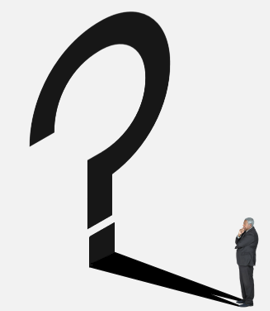

## **Assignment #2**: Code a MC Dropout-based version of ResNet18

In [14]:
class ResNetMC(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(ResNetMC, self).__init__()
        self.mc_dropout = mc_dropout
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_b(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_c(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_d(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_e(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.global_pool(x)
        return self.classifier(x)

## Load EMNIST

In [15]:
def show_images_from_npy(array, cmap=None):
    fig, ax = plt.subplots(1, 5)
    ax = ax.ravel()
    j = 0
    for idx in np.random.randint(0, array.shape[0], 5):
        ax[j].imshow(array[idx], cmap=cmap)
        ax[j].axis('off')
        j += 1
emnist = np.load(os.path.join(ROOTDIR_DATA, "emnist_images.npy"))
emnist_numpy = (emnist / 255).astype(np.float32)

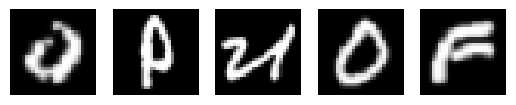

In [16]:
show_images_from_npy(emnist_numpy, cmap="gray")

N.B. Do not shuffle emnist

In [49]:
emnist = tf.data.Dataset.from_tensor_slices(emnist_numpy).cache().batch(128).prefetch(tf.data.AUTOTUNE)

## **Assignment #3**: Code a wrapper for a MC-based network
Implements:
1.   Several metrics to compute uncertainty
2.   Method to reierate predictions


In [54]:
class UncertaintyWrapper(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(UncertaintyWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetMC(mc_dropout=mc_dropout)
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
      return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        if len(multiple_preds.shape)>2:
          return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis = 1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.var( avg_preds, axis= 1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max( avg_preds, axis= 1)

In [55]:
net_unc = UncertaintyWrapper(mc_dropout=0.1)
net_unc.build((1, 28, 28, 1))
net_unc.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_unc.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net_unc.fit(mnist_train, epochs=1)
print("Accuracy on test set: {:.2f}".format(net_unc.evaluate(mnist_test)[1]))

MC Dropout is set to 0.1
Model: "uncertainty_wrapper_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_mc_2 (ResNetMC)     multiple                  11186186  
                                                                 
Total params: 11,186,186
Trainable params: 11,178,378
Non-trainable params: 7,808
_________________________________________________________________
79/79 [==============================] - 1s 10ms/step - loss: 0.3005 - accuracy: 0.9001
Accuracy on test set: 0.90


## Compute MC predicitons and compare with *deterministic* uncertainty computation

In [56]:
multiple_preds_emnist = net_unc.predict_many_times(emnist, draws=10)
multiple_preds_mnist = net_unc.predict_many_times(mnist_test, draws=10)

79/79 [==============================] - 0s 6ms/step


In [58]:
preds_mnist = net_unc.predict(mnist_test)
preds_emnist= net_unc.predict(emnist)

79/79 [==============================] - 1s 7ms/step


In [59]:
uncertainties = dict()
uncertainties_deterministic = dict()
uncertainties['mnist'] = net_unc.uncertainty_metrics(multiple_preds_mnist)
uncertainties['emnist'] = net_unc.uncertainty_metrics(multiple_preds_emnist)
uncertainties_deterministic['mnist'] = net_unc.uncertainty_metrics(preds_mnist)
uncertainties_deterministic['emnist'] = net_unc.uncertainty_metrics(preds_emnist)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [62]:
uncertainties

{'mnist': {'entropy': array([0.06599457, 0.08784804, 0.04270675, ..., 0.14415537, 0.02226103,
         0.00717567], dtype=float32),
  'variance': array([0.95265543, 0.93110156, 0.9680483 , ..., 0.8701394 , 0.9865637 ,
         0.9962879 ], dtype=float32),
  'max_softmax_response': array([0.97374344, 0.9615119 , 0.9823189 , ..., 0.92579097, 0.9926179 ,
         0.9979659 ], dtype=float32)},
 'emnist': {'entropy': array([0.5862538 , 0.63781005, 0.6517356 , ..., 0.4475399 , 0.3202009 ,
         0.7847561 ], dtype=float32),
  'variance': array([0.2992589 , 0.32223836, 0.21145345, ..., 0.4464404 , 0.5875545 ,
         0.1114711 ], dtype=float32),
  'max_softmax_response': array([0.47747397, 0.5347219 , 0.34438637, ..., 0.60661787, 0.72931135,
         0.18926686], dtype=float32)}}

In [63]:
uncertainties_deterministic


{'mnist': {'entropy': array([0.04502572, 0.01581217, 0.01991487, ..., 0.00308048, 0.0026052 ,
         0.00297356], dtype=float32),
  'variance': array([0.9684321, 0.9910889, 0.9866299, ..., 0.9983548, 0.9987908,
         0.9985611], dtype=float32),
  'max_softmax_response': array([0.9824117 , 0.9950707 , 0.9925891 , ..., 0.9990914 , 0.99933237,
         0.9992054 ], dtype=float32)},
 'emnist': {'entropy': array([0.10572366, 0.78456634, 0.6912584 , ..., 0.16038658, 0.7248207 ,
         0.59982723], dtype=float32),
  'variance': array([0.9055002 , 0.11702581, 0.20568432, ..., 0.8473753 , 0.19140796,
         0.28789687], dtype=float32),
  'max_softmax_response': array([0.94871795, 0.21368359, 0.38230956, ..., 0.9153378 , 0.34932128,
         0.46390787], dtype=float32)}}

## **Assignment #4** Uncertainty metrics distributions for MNIST and EMNIST
Plot distributions in form of histograms


(array([  25.,  136.,  339.,  499.,  618.,  650.,  686.,  696.,  587.,
         602.,  504.,  503.,  498.,  422.,  424.,  407.,  434.,  414.,
         469., 1087.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

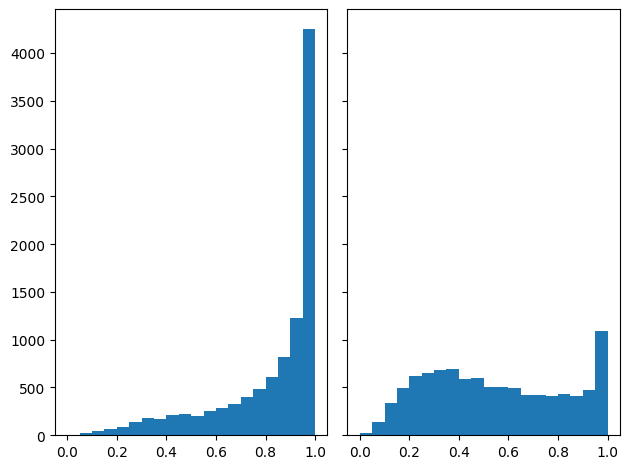

In [75]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(uncertainties['mnist']['max_softmax_response'], bins=20)
axs[1].hist(uncertainties['emnist']['max_softmax_response'], bins=20)

## **Assignment #5** Take a look at confident and not-confident predictions for EMNIST
Filter confident and not-confident images based on uncertainty values and plot some of them

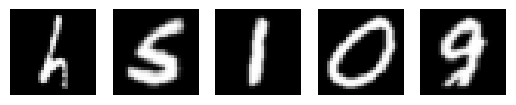

In [85]:
confidents = np.where(uncertainties['emnist']['max_softmax_response'] >= 0.9)[0]
show_images_from_npy(emnist_numpy[confidents], cmap='gray')

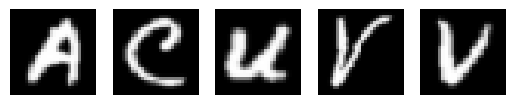

In [86]:
not_confidents = np.where(uncertainties['emnist']['max_softmax_response'] <= 0.9)[0]
show_images_from_npy(emnist_numpy[not_confidents], cmap='gray')

# Uncertainty in DL - Ensamble

In [87]:
nets = list()
for _ in range(3):
    net = ResNet()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
    net.fit(mnist_train, epochs=3)
    nets.append(net)

Epoch 1/3
469/469 [==============================] - 17s 26ms/step - loss: 0.1341 - accuracy: 0.9584
Epoch 2/3
469/469 [==============================] - 12s 25ms/step - loss: 0.0349 - accuracy: 0.9889
Epoch 3/3
469/469 [==============================] - 12s 25ms/step - loss: 0.0178 - accuracy: 0.9944
Epoch 1/3
469/469 [==============================] - 19s 29ms/step - loss: 0.1362 - accuracy: 0.9580
Epoch 2/3
469/469 [==============================] - 14s 29ms/step - loss: 0.0367 - accuracy: 0.9883
Epoch 3/3
469/469 [==============================] - 13s 28ms/step - loss: 0.0187 - accuracy: 0.9939
Epoch 1/3
469/469 [==============================] - 18s 25ms/step - loss: 0.1411 - accuracy: 0.9564
Epoch 2/3
469/469 [==============================] - 14s 30ms/step - loss: 0.0384 - accuracy: 0.9879
Epoch 3/3
469/469 [==============================] - 11s 24ms/step - loss: 0.0175 - accuracy: 0.9945


In [88]:
emnist_preds_ensamble = list()
mnist_preds_ensamble = list()
for net in nets:
    emnist_preds_ensamble.append(net.predict(emnist))
    mnist_preds_ensamble.append(net.predict(mnist_test))

79/79 [==============================] - 1s 7ms/step


In [89]:
uncertainties_ensable = dict()
uncertainties_ensable['mnist'] = net_unc.uncertainty_metrics(np.array(mnist_preds_ensamble))
uncertainties_ensable['emnist'] = net_unc.uncertainty_metrics(np.array(emnist_preds_ensamble))

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


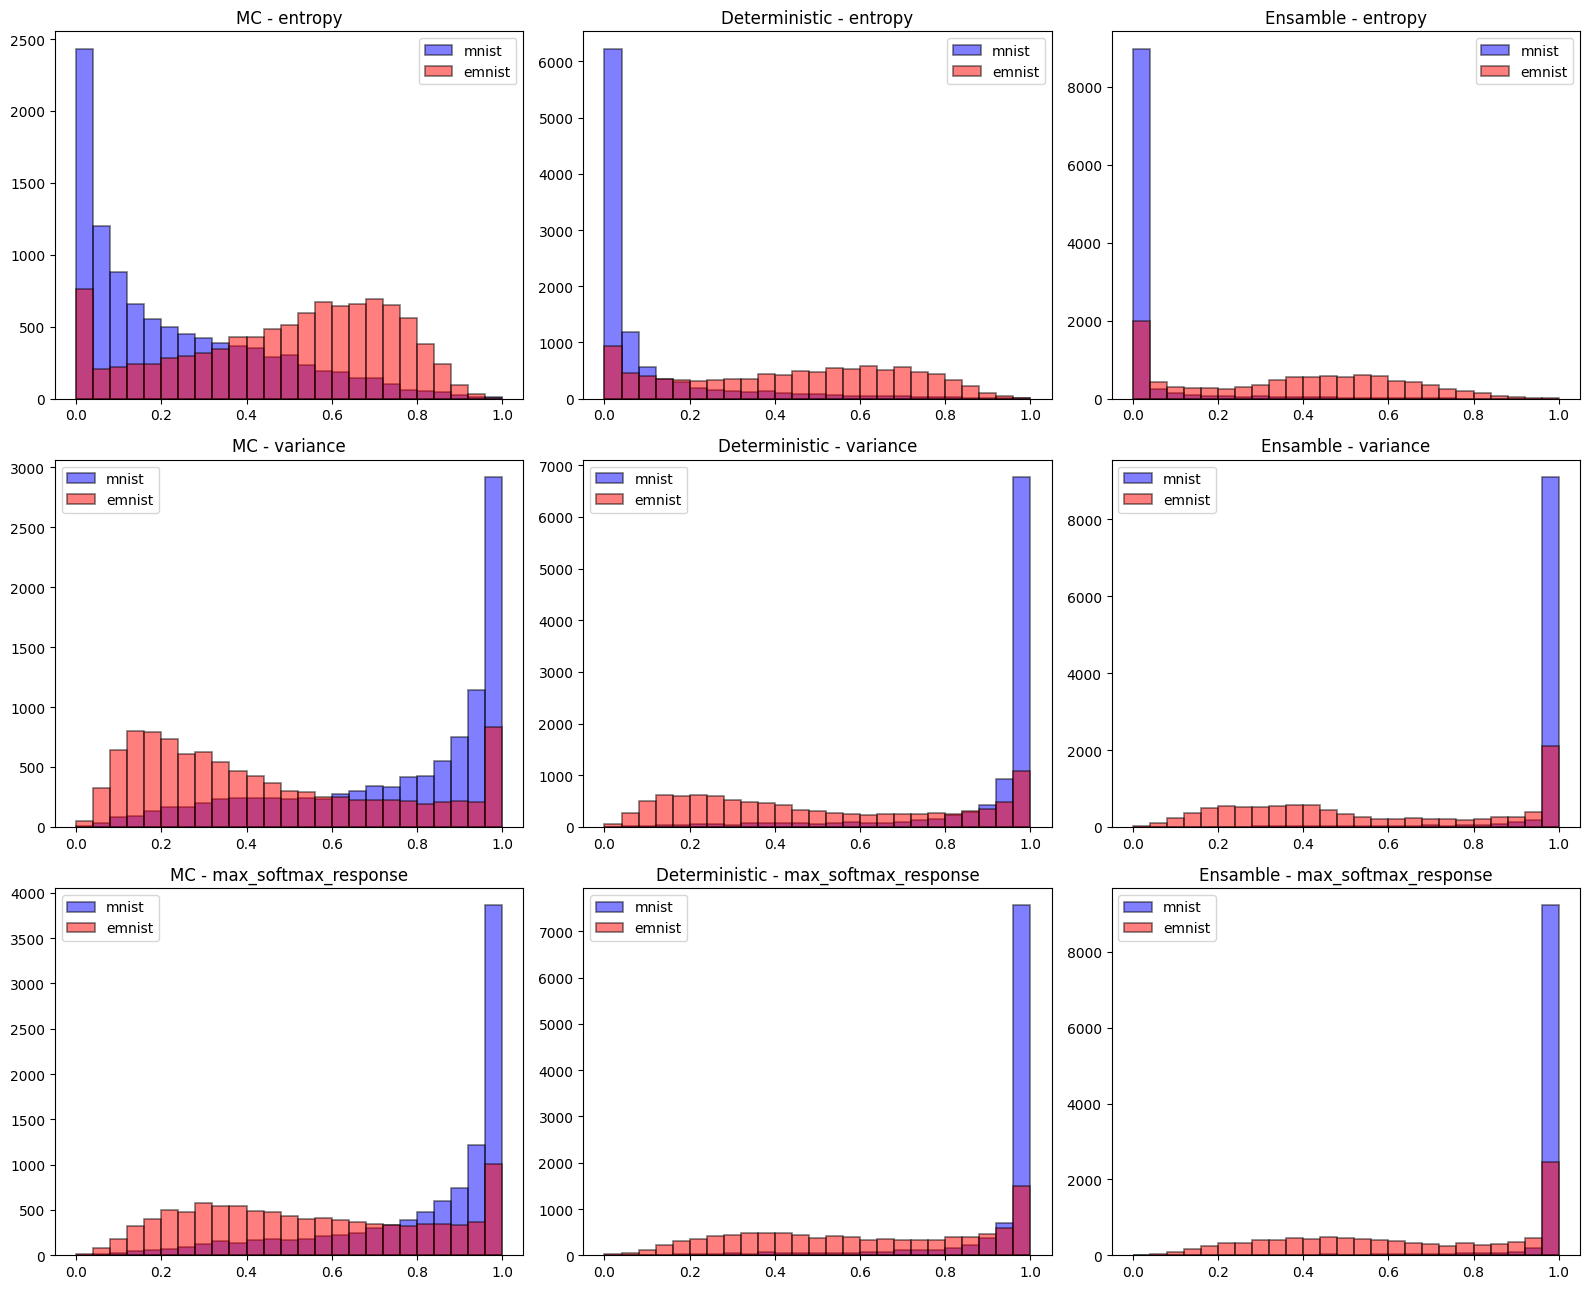

In [90]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 3, figsize=(16, 13))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
plt.tight_layout()

In [91]:
import tensorflow_probability as tfp
# 
tfd = tfp.distributions
NUM_TRAIN_EXAMPLES = 50000
NUM_CLASSES = 10
LR = 0.01

# Uncertainty in DL - Variational Inference

In [92]:
class ResidualVI(tf.keras.Model):
    """The Residual block of ResNet."""
    
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                                       tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        self.conv1 = tfp.layers.Convolution2DFlipout(
            num_channels, 
            kernel_size=3, 
            padding='same',
            strides=strides,
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv2 = tfp.layers.Convolution2DFlipout(
            num_channels, 
            kernel_size=3, 
            padding='same',
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
            
            self.conv_1x1 = tfp.layers.Convolution2DFlipout(
                num_channels, 
                kernel_size=1, 
                strides=strides,
                kernel_divergence_fn=self.kl_divergence_function)

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlockVI(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlockVI, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    ResidualVI(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(ResidualVI(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

class ResNetVI(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNetVI, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlockVI(64, 2, downscale=False)
        self.block_c = ResnetBlockVI(128, 2)
        self.block_d = ResnetBlockVI(256, 2)
        self.block_e = ResnetBlockVI(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

In [93]:
class VIWrapper(tf.keras.Model):
    
    def __init__(self, num_classes=10, mc_dropout=None):
        super(VIWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetMC(mc_dropout=mc_dropout)
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
      return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        if len(multiple_preds.shape)>2:
          return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis = 1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.var( avg_preds, axis= 1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max( avg_preds, axis= 1)

In [94]:
net_vi = VIWrapper()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# The Keras API will automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
net_vi.compile(optimizer, loss='categorical_crossentropy',
               metrics=['accuracy'], experimental_run_tf_function=False)

MC Dropout is set to None


In [95]:
net_vi.fit(mnist_train, epochs=3)

Epoch 1/3
469/469 [==============================] - 26s 26ms/step - loss: 0.2844 - accuracy: 0.9260
Epoch 2/3
469/469 [==============================] - 12s 26ms/step - loss: 0.0687 - accuracy: 0.9797
Epoch 3/3
469/469 [==============================] - 12s 26ms/step - loss: 0.0521 - accuracy: 0.9848


In [96]:
print("Accuracy on test set: {:.2f}".format(net_vi.evaluate(mnist_test)[1]))
preds_mnist = net_vi.predict(mnist_test)

79/79 [==============================] - 1s 7ms/step - loss: 0.0833 - accuracy: 0.9761
Accuracy on test set: 0.98
79/79 [==============================] - 1s 6ms/step


In [97]:
vi_preds_emnist = net_vi.predict_many_times(emnist, draws=10)
vi_preds_mnist = net_vi.predict_many_times(mnist_test, draws=10)

79/79 [==============================] - 0s 6ms/step


In [98]:
uncertainties_vi = dict()
uncertainties_vi['mnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_mnist))
uncertainties_vi['emnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_emnist))

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


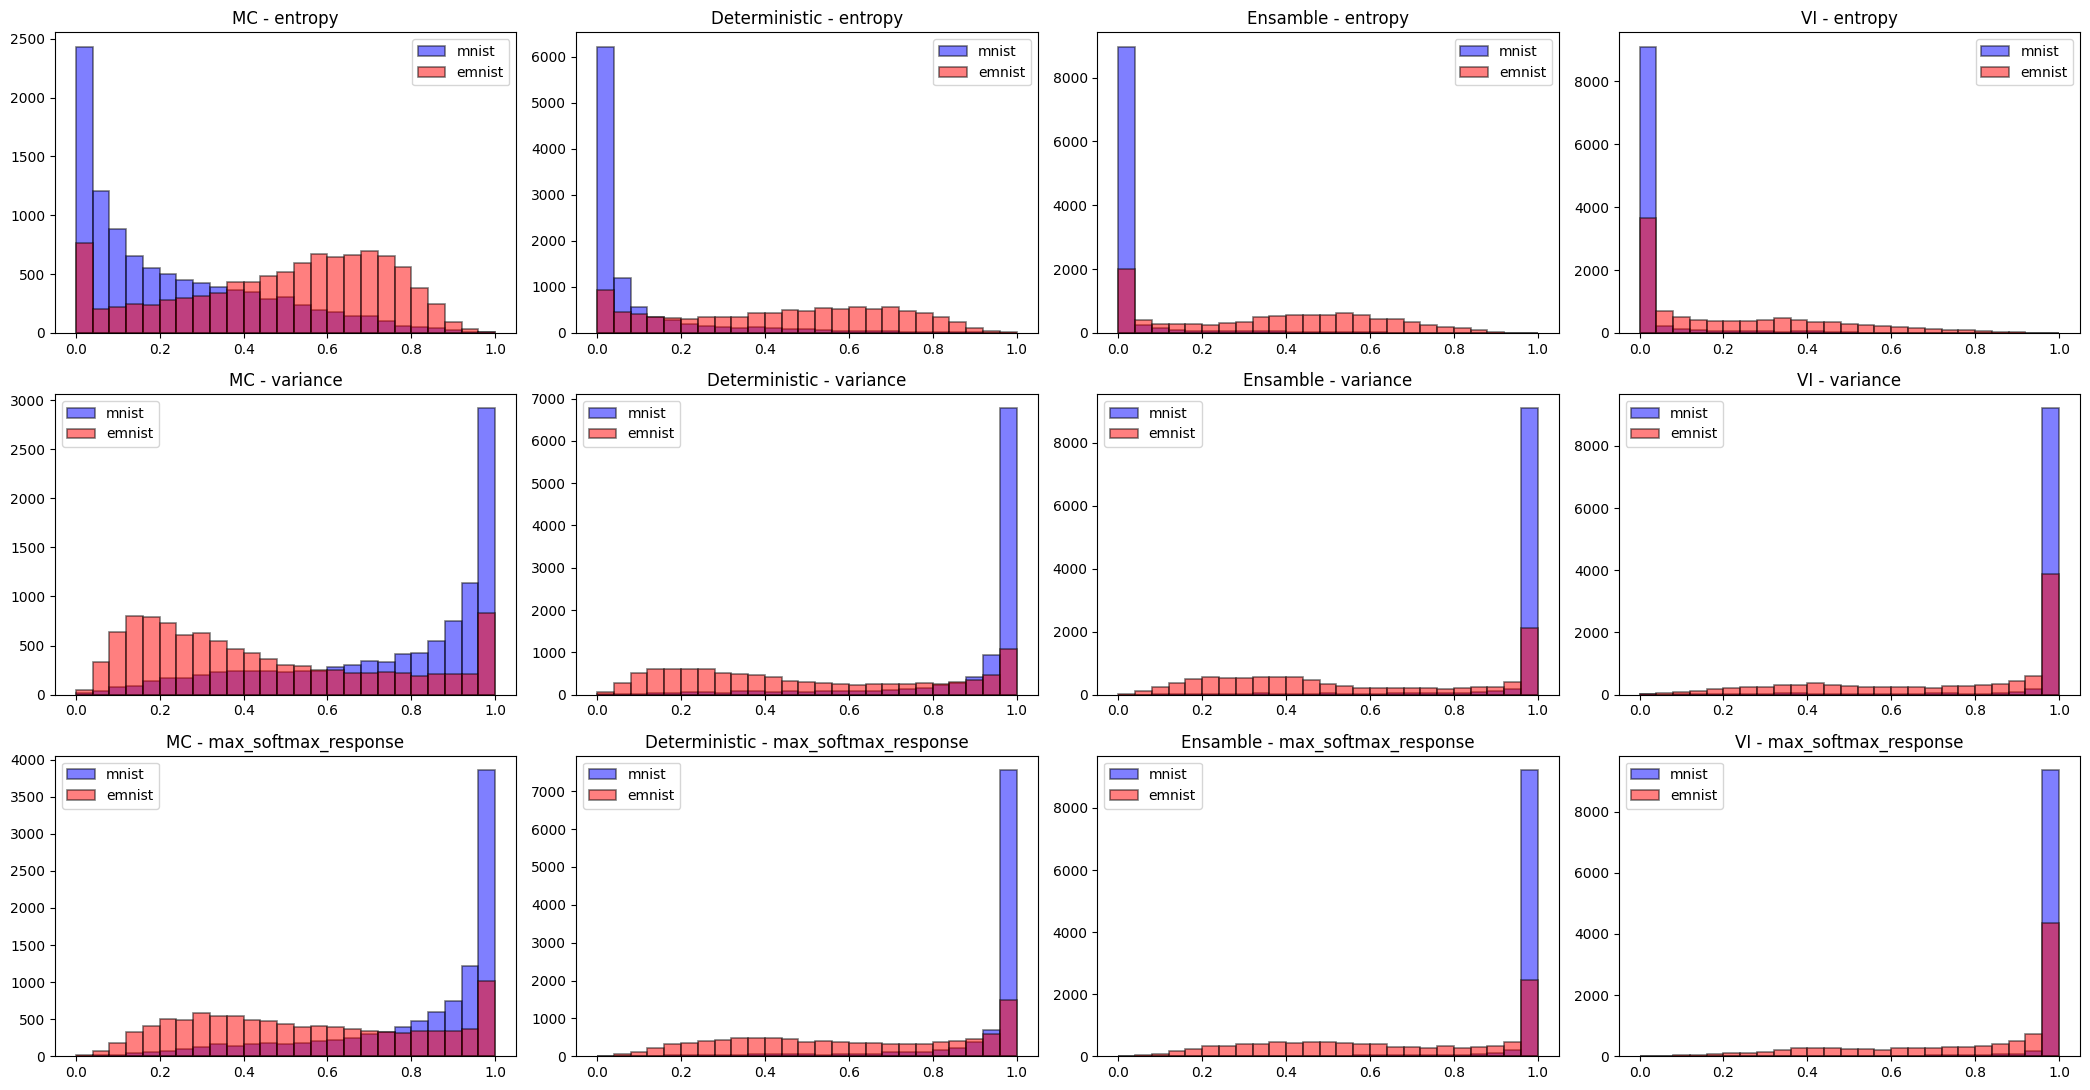

In [99]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 4, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3] .set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
plt.tight_layout()

## **Assignment #6** Uncertainty in DL - Test Time Augmentation-Based
See [data augmentation for tensorflow and keras](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
class TTAWrapper(UncertaintyWrapper):
    def __init__(self, num_classes=10):
        super(TTAWrapper, self).__init__()
        self.model = ResNet()
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()

        [...]
        
        return pred_augmented

In [ ]:
net_tta = TTAWrapper()
net_tta.build((1, 28, 28, 1))
net_tta.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_tta.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net_tta.fit(mnist_train, epochs=3)
print("Accuracy on test set: {:.2f}".format(net_tta.evaluate(mnist_test)[1]))

In [ ]:
emnist_preds_tta = net_tta.predict_many_times(emnist, "random_zoom", repeat=10)
mnist_preds_tta = net_tta.predict_many_times(mnist_test, "random_zoom", repeat=10)

In [ ]:
uncertainties_tta = dict()
uncertainties_tta['mnist'] = net_tta.uncertainty_metrics(np.array(mnist_preds_tta))
uncertainties_tta['emnist'] = net_tta.uncertainty_metrics(np.array(emnist_preds_tta))
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 5, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3] .set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
    ax[4].set_title(f"TTA - {measure}")
    ax[4].hist(uncertainties_tta['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[4].hist(uncertainties_tta['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[4].legend()
plt.tight_layout()